This notebook illustrates the motion of an electron in spatially dependent magnetic and electric fields perpendicular to each other. This uses the Runge-Kutta method to evolve particle's equation of motion.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp
import sys
import os

In [88]:
#parameters in cgs units
m = 9.1e-27 #electron's mass in CGS units (gram)
e = 5.e-10 #electron's charge in CGS units (esu) 
qbym = -e/m #electron's charge to mass ratio 
c = 3.e10 #speed of light

fields same as in Fig. 1 of Qin+ paper https://ui.adsabs.harvard.edu/abs/2013PhPl...20h4503Q/abstract

${\bf B} = \sqrt{x^2+y^2} {\bf \hat{z}}$ 

$\phi = \frac{0.01}{\sqrt{x^2+y^2}}$

${\bf E} = -{\bf \nabla} \phi$

A constant electric field (or a constant force in general) perpendicular to a constant magnetic field, causes a drift perpendicular to both ${\bf E}$ and ${\bf B}$, ${\bf u_\perp} = \frac{c({\bf E} \times {\bf B})}{B^2} \left ( \frac{c({\bf F} \times {\bf B})}{qB^2} {\rm~for~a~general~force}\right)$. While E cross B drift is independent of the charge, for a general force electrons and protons drift in the opposite directions leading to currents perpendicular to B.

In [89]:
def cal_E_par(x): 
    return 0.0 

def cal_E_perp(x):
    return 0.01*np.array([x[0],x[1]])/(x[0]*x[0]+x[1]*x[1])**1.5

def cal_B(x):
    return (x[0]*x[0]+x[1]*x[1])**0.5

The RHS of the equation of motion is returned by the following function:

$\frac{d}{dt} \left[ \begin{matrix} x \\ y \\ z \\ v_x \\ v_y \\ v_z \end{matrix} \right] = \left[ \begin{matrix} v_x \\ v_y \\ v_z \\ F_x/m \\ F_y/m \\ F_z/m \end{matrix} \right] $

In [90]:
def fun_pp(t, y, B, qbym, c): #returns the RHS for equation of motion 
    rhs_pp = 0.0*y
    rhs_pp[0] = y[3]
    rhs_pp[1] = y[4]
    rhs_pp[2] = y[5]
    E_perp = cal_E_perp(y[:3])
    E_par = cal_E_par(y[:3])
    B = cal_B(y[:3])
    rhs_pp[3] = qbym*(E_perp[0] + y[4]*B/c)
    rhs_pp[4] = qbym*(E_perp[1] - y[3]*B/c)
    rhs_pp[5] = qbym*E_par
    return rhs_pp

In [91]:
#initial conditions not explicitly stated in the paper; following arrived from a lot guessing; remember drift formulae are valid in asymptotic limit only
xi, yi, zi = 5, 0, 0 #initial coordinates
E_perp = np.sqrt(np.sum(cal_E_perp([xi, yi, zi])**2)) #magnitude of Eperp
B = cal_B([xi, yi, zi]) #get value of B at particle position
w_c = e*B/(m*c) #local cyclotron angular frequency
v_EB_D = c*E_perp/B #magnitude of ExB drift
v_perp = np.abs(qbym*E_perp*0.25*2*np.pi/w_c) #not the true value, just an estimate! particle accelerates for T_cyc/4 because of Larmor motion
v_mugradB_D = 0.5*v_perp*v_perp/(w_c*np.sqrt(xi*xi+yi*yi+zi*zi)) #estimate of mu gradB velocity
print("Larmor radius = ", v_perp/w_c) 
print("E cross B drift velocity = ", v_EB_D/c) 
print("grad B drift in units of c = ", v_mugradB_D/c)
print("v/c perpendicular to B = ", v_perp/c) #print out some useful parameters
print("Larmor period = ", 2.*np.pi/w_c)
print("Time period of drift circle", 2.*np.pi*np.sqrt(xi*xi+yi*yi+zi*zi)/v_EB_D) #print out some more useful parameters
n_dump = 100000 #number of time dumps of x, v of the particle
vxi, vyi, vzi = 0, 0, 0 #initial velocities

Larmor radius =  0.41167430132640653
E cross B drift velocity =  8e-05
grad B drift in units of c =  5.173251842874999e-06
v/c perpendicular to B =  0.00012566370614359174
Larmor period =  6.861238355440109e-07
Time period of drift circle 1.308996938995747e-05


In [92]:
#set initial conditions to supply to ODE solver
y0 = np.array([xi, yi, zi, vxi, vyi, vzi])
tend = 5000*2.0*np.pi/w_c #evolve for 5000 Larmor orbits

In [93]:
#RK4 update
sol = solve_ivp(fun_pp, [0,tend], y0, t_eval = np.linspace(0,tend,n_dump+1), args = (B, qbym, c), method = 'RK45')

Text(0.5, 1.0, 'late time radius')

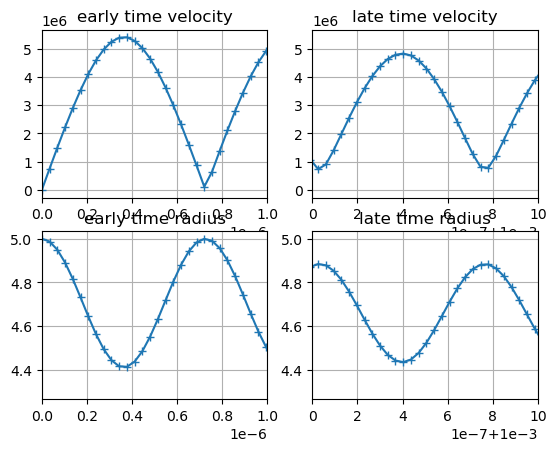

In [94]:
plt.subplot(221)
plt.plot(sol.t, np.sqrt(sol.y[3,:]**2+sol.y[4,:]**2), '-+')
plt.xlim([0.0,0.0+1e-6]) #early time velocity vs time
plt.grid()
plt.title("early time velocity")
plt.subplot(222)
plt.plot(sol.t, np.sqrt(sol.y[3,:]**2+sol.y[4,:]**2), '-+')
plt.xlim([0.001,0.001+1e-6]) #velocity at later times
plt.grid()
plt.title("late time velocity")
plt.subplot(223)
plt.plot(sol.t, np.sqrt(sol.y[0,:]**2+sol.y[1,:]**2), '-+')
plt.xlim([0.0,0.0+1e-6]) #radius evolution at early times
plt.grid()
plt.title("early time radius")
plt.subplot(224)
plt.plot(sol.t, np.sqrt(sol.y[0,:]**2+sol.y[1,:]**2), '-+')
plt.xlim([0.001,0.001+1e-6]) #radius evolution at late times
plt.grid()
plt.title("late time radius")

Text(0.5, 1.0, 'late times')

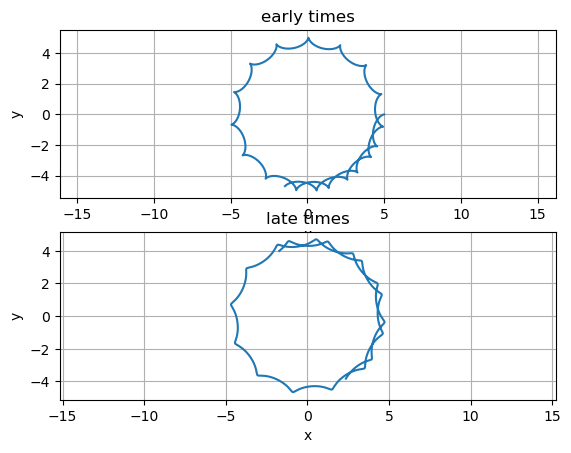

In [97]:
#early time
plt.subplot(211)
plt.plot(sol.y[0,:400], sol.y[1,:400]) #show evolution for short times
#plt.axis('equal')
plt.grid()
#print(0.1*w_c, 0.01*c)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title("early times")
#plt.xlim([3,5])

#late time
plt.subplot(212)
plt.plot(sol.y[0,-400:], sol.y[1,-400:]) #show evolution for short times
#plt.axis('equal')
plt.grid()
#print(0.1*w_c, 0.01*c)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title("late times")
#plt.xlim([3,5])

Text(0, 0.5, 'y')

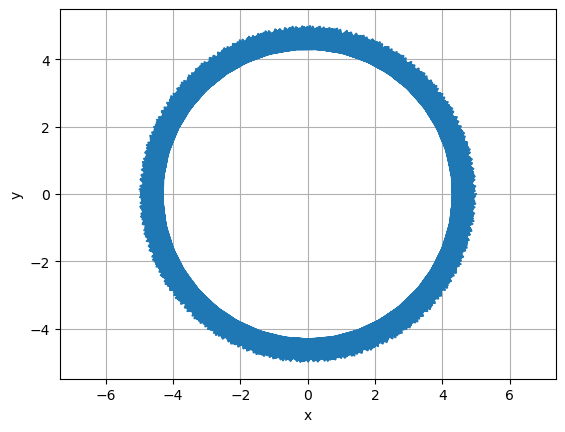

In [96]:
plt.plot(sol.y[0,:], sol.y[1,:]) #show evolution for all times
plt.grid()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')